## Introduction to Parameter Estimation or Inverse Problems

In [14]:
using ContinuousTransformations

In [2]:
using OrdinaryDiffEq, ParameterizedFunctions, DiffEqBayes, Plots, RecursiveArrayTools

[Turing]: AD chunk size is set as 40



ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.

Parameter Estimation in one line can be described as obtaining parameters for mathematical models by data fitting. 

Let's discuss what that implies specifically in context of our interest here, which are Differential Equation Models. The general structure of a differential equation model can be described as 
$$\mathbf{\dot{x}}(\textit{t}) = f(\textbf{x}(\textit{t}), \textbf{u}, \textit{t} \hspace{0.1cm}|\hspace{0.1cm} \theta)$$

Here, $t$ denotes the independent variable, usually time, $\theta$ is a p-dimensional vector of unknown parameters, $x = x(t,\theta)$ is an n-dimensional state variable vector depending on $t$ and $\theta$, and thus the function $f(t,x,\theta)$ maps $R\times R^n\times R^p$ into $R^n$.

We are interested in obtaining this vector $\theta$ with the help of data describing the trajectory of the solution of our equation with some noise, to give you a more intuitive understanding of how different parameter values affect the solutions let's take a look at FitzHugh-Nagumo model which is often used as a generic model for excitable media such as a neuron.

In [3]:
fitz = @ode_def_nohes FitzhughNagumo begin
  dv = v - v^3/3 -w + l
  dw = τinv*(v +  a - b*w)
end a b τinv l
u0 = [1.0;1.0]
tspan = (0.0,100.0)
p = [0.7,0.8,1/12.5,0.5]
prob = ODEProblem(fitz,u0,tspan,p)


DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [1.0, 1.0]

#### With $\theta$ as [0.7,0.8,1/12.5,0.5]

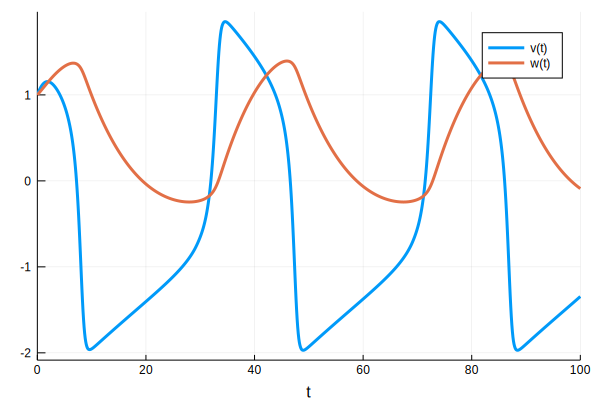

In [4]:
sol = solve(prob,Tsit5())
plot(sol)

#### With $\theta$ as [2.0,2.0,1/15,1.0]

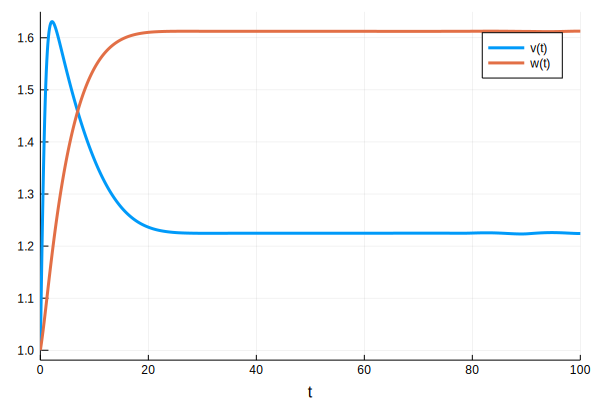

In [17]:
p = [2.0,2.0,1/15,1.0]
prob = ODEProblem(fitz,u0,tspan,p)
sol = solve(prob,Tsit5())
plot(sol)

Now let's suppose you know that the model that you want to use is FitzHugh-Nagumo, you have some data points with some noise as depicted below.

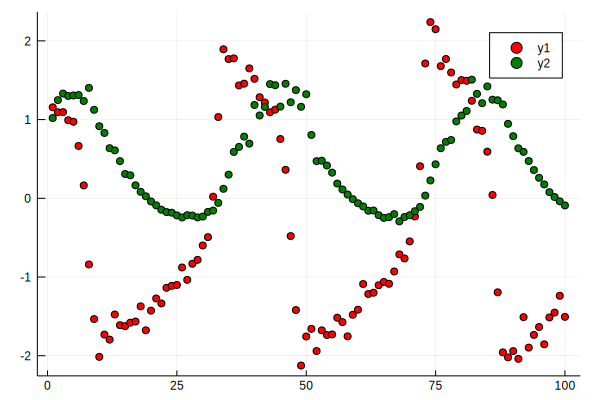

In [5]:
t = collect(linspace(1,100,100))
rand_sol = VectorOfArray([(sol(t[i]) + .1randn(2).*sol(t[i])) for i in 1:length(t)])
scatter(t,rand_sol[1,:],color=:red)
scatter!(t,rand_sol[2,:],color=:green)

So our problem now becomes pretty much this, what values of $\theta$ can we get such that the model adequately describes this exact phenomena given that we are sure that the model is correct, this part of the scientific modelling pipeline is parameter estimation.

Now let's look at this problem from a Bayesian Perspective.

Quick refresher, Bayes' Theorem 

$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$


This provides us with a convenient way to frame our problem, let's take the event of getting our noisy data points as B and the event of getting a specific $\theta$ as A. So $P(A \mid B)$ is the *Posterior* and it represents the probability of our current set of parameters, $\theta$ conditioned on our noisy data. $P(B \mid A)$ is known as the *Likelihood*, it represents the probability of our data conditioned on our current $\theta$, $P(A)$ is the *Prior* probability of the current $\theta$ and $P(B)$ is the probability of observing our data, which is going to be constant irrespective of $\theta$.

As is the trend in such problems, now we aim to maximize the $P(A \mid B)$ (actually the $log$ of it) which would give us the best set of parameters $\theta$ thst describe our data.

### What we do in DiffEqBayes. 

Let's go through an example problem, the one mentioned above, the FitzHugh-Nagumo model. We will try to predict the parameters using the random data we created.

In [7]:
priors = [Truncated(Normal(0.7,0.2),0.0,1.0),Truncated(Normal(0.8,0.2),0,1.0),Truncated(Normal(0.0,0.1),0.0,0.2),Truncated(Normal(0.5,0.1),0,1)]

4-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=0.7, σ=0.2), range=(0.0, 1.0))
 Truncated(Distributions.Normal{Float64}(μ=0.8, σ=0.2), range=(0.0, 1.0))
 Truncated(Distributions.Normal{Float64}(μ=0.0, σ=0.1), range=(0.0, 0.2))
 Truncated(Distributions.Normal{Float64}(μ=0.5, σ=0.1), range=(0.0, 1.0))

In [68]:
@time bayesian_result_turing = turing_inference(prob,Tsit5(),t,rand_sol,priors;num_samples=10000)

[Turing] looking for good initial eps...
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.NUTS] found initial ϵ: 0.05
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00029701776411020014; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:8

[NUTS] Sampling...  0%  ETA: 0:28:26
  ϵ:         0.002768915357191236
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[Turing.WARNING]: Incorrect ϵ = 3.76670287784175e-5; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.1450192088933924e-5; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.2723058905370729e-5; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.802089378121578e-6; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64

[NUTS] Sampling...  0%  ETA: 0:11:43
  ϵ:         0.002768915357191236
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[Turing.WARNING]: Incorrect ϵ = 7.162322213544415e-9; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.543831390778502e-9; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.308052368184352e-9; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.360355030098874e-9; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  0%  ETA: 0:11:19
  ϵ:         0.002768915357191236
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[Turing.WARNING]: Incorrect ϵ = 2.1696881463711475e-10; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.755921037689017e-10; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.4241515889389208e-10; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.1575006533350364e-10; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::F

[NUTS] Sampling...  1%  ETA: 0:10:05
  ϵ:         0.002768915357191236
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[Turing.WARNING]: Incorrect ϵ = 2.2083554675130876e-12; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.8573657338565474e-12; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.5639886751752857e-12; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3184603546199312e-12; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::

[NUTS] Sampling...  1%  ETA: 0:10:04
  ϵ:         0.002768915357191236
  pre_cond:  [1.0, 1.0, 1.0, 1.0, 1.0]

[Turing.WARNING]: Incorrect ϵ = 1.573970826599339e-13; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3454605888919092e-13; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.151121590690807e-13; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.856915973643569e-14; ϵ_previous = 0.002768915357191236 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Flo

[NUTS] Sampling...  1%  ETA: 0:10:13
  ϵ:         0.014062383011396173
  pre_cond:  [0.0136176, 0.0131295, 0.01302...

[Turing.WARNING]: Incorrect ϵ = 0.0007787509655792003; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00039263928941713806; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.0002201021590121641; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00013270216771716235; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Fl

[NUTS] Sampling...  1%  ETA: 0:10:00
  ϵ:         0.006566356211966846
  pre_cond:  [0.0136176, 0.0131295, 0.01302...

[Turing.WARNING]: Incorrect ϵ = 8.944791331667381e-7; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.250162828798337e-7; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.903092964125885e-7; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.826521609145512e-7; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  1%  ETA: 0:09:46
  ϵ:         0.006566356211966846
  pre_cond:  [0.0136176, 0.0131295, 0.01302...

[Turing.WARNING]: Incorrect ϵ = 3.405655055416831e-8; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.9073870591214757e-8; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.4864935827074204e-8; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.130227210969997e-8; ϵ_previous = 0.006566356211966846 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  2%  ETA: 0:10:12

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.0007799495853007978; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00039324362278758766; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00022044093071225685; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00013290641714

[NUTS] Sampling...  2%  ETA: 0:09:59
  ϵ:         0.00657646286274813
  pre_cond:  [0.0105958, 0.0148792, 0.00982...

[Turing.WARNING]: Incorrect ϵ = 1.110614046889459e-6; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.95855876666213e-7; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.261321965076167e-7; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.912178748873466e-7; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at a

[NUTS] Sampling...  2%  ETA: 0:09:50
  ϵ:         0.00657646286274813
  pre_cond:  [0.0105958, 0.0148792, 0.00982...

[Turing.WARNING]: Incorrect ϵ = 3.410896892017752e-8; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.9118619832261078e-8; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.4903206858220152e-8; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.1335059643319913e-8; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) 

[NUTS] Sampling...  2%  ETA: 0:09:32
  ϵ:         0.00657646286274813
  pre_cond:  [0.0105958, 0.0148792, 0.00982...

[Turing.WARNING]: Incorrect ϵ = 1.2951577216940166e-9; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.1392424481162068e-9; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0030265556741132e-9; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.838986103068268e-10; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  2%  ETA: 0:09:19

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0394490983290217e-10; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.290245793210794e-11; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.308410354680628e-11; ϵ_previous = 0.00657646286274813 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.434828627465023

[NUTS] Sampling...  3%  ETA: 0:09:10

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 0.00013311098093487527; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.464283929627955e-5; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.60568753335237e-5; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.833615185472524

[NUTS] Sampling...  3%  ETA: 0:08:56

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.8679808147567375e-7; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.558740309003798e-7; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3043160928314188e-7; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.09431066155924

[NUTS] Sampling...  3%  ETA: 0:08:46
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 3.752808199729844e-9; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.2738150106209096e-9; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.8591833527303316e-9; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.499811965620925e-9; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  3%  ETA: 0:08:30
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 1.463681020152293e-10; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3056957927558542e-10; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.165516798490014e-10; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0410489733133545e-10; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Fl

[NUTS] Sampling...  4%  ETA: 0:08:19
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 9.040133619068219e-12; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.176940537334706e-12; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.399387346527363e-12; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 6.698647594857283e-12; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Floa

[NUTS] Sampling...  4%  ETA: 0:08:12
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 8.282272529464765e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.562244326766596e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 6.907039479005347e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.040164396235234e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Floa

[NUTS] Sampling...  4%  ETA: 0:08:10
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 1.306882323720619e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.2005925393356662e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.1032354235644292e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0140353726748576e-13; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::F

[NUTS] Sampling...  4%  ETA: 0:08:09
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 2.7207689568130087e-14; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.5109613696088645e-14; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.3178444516412672e-14; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.1400486097690278e-14; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::

[NUTS] Sampling...  4%  ETA: 0:08:09
  ϵ:         0.006586585069248099
  pre_cond:  [0.00956699, 0.00809788, 0.008...

[Turing.WARNING]: Incorrect ϵ = 6.140139180000127e-15; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.688824418142643e-15; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.271683565270396e-15; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.886051160509076e-15; ϵ_previous = 0.006586585069248099 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Floa

[NUTS] Sampling...  5%  ETA: 0:08:08

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0466325248735874e-5; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.866323065952847e-6; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.981676935468164e-6; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.595714870531573e-6

[NUTS] Sampling...  5%  ETA: 0:08:10
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.8708559298360077e-7; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.56113945450448e-7; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.306323639609742e-7; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0959949770830416e-7; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at

[NUTS] Sampling...  5%  ETA: 0:08:01

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.2788539247411236e-9; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.863584083780074e-9; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.5036595678130407e-9; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.1913209569018045e

[NUTS] Sampling...  5%  ETA: 0:07:57
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.644389931842753e-10; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.4659338545170962e-10; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3077054631084785e-10; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.167310711412462e-10; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  6%  ETA: 0:07:49
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.1081226711595314e-11; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0014246352818204e-11; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.054047800777926e-12; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.189526129678823e-12; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  6%  ETA: 0:07:45

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0918666241896848e-12; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.959587579592813e-13; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.087780667310411e-13; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.295020244244247

[NUTS] Sampling...  6%  ETA: 0:07:44
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.3088938203302594e-13; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.2024404393176308e-13; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.1049334756949511e-13; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0155961319545331e-13; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Floa

[NUTS] Sampling...  6%  ETA: 0:07:41
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 2.3214119773255056e-14; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.143342479802223e-14; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.979362022272762e-14; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.8283209410947378e-14; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  6%  ETA: 0:07:38
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 3.900651491954004e-15; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.617989444411812e-15; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.3564203122805e-15; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.114323423907336e-15; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) a

[NUTS] Sampling...  7%  ETA: 0:07:33
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 5.834051591261782e-16; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.434780976342001e-16; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.063604958879675e-16; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.718491209869721e-16; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  7%  ETA: 0:07:31
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.1077754486461436e-16; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0354724435724983e-16; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.680154333360387e-17; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.050709194099622e-17; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  7%  ETA: 0:07:26
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.9952267386178534e-17; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.8709365144431566e-17; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.7545877279746177e-17; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.743782678032895e-17; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float

[NUTS] Sampling...  7%  ETA: 0:07:23
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 4.392199512701684e-18; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.225933932314044e-18; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.882288109827933e-18; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.650528615820939e-18; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  8%  ETA: 0:07:20
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 9.656336694379167e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.8667693334674745e-18; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.575745239288301e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.08275729813044e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  8%  ETA: 0:07:19
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 2.825793929752482e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.667653152942766e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.518567339369244e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.112988811227614e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64)

[NUTS] Sampling...  8%  ETA: 0:07:19
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.0329144642083267e-19; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.573010569610416e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.106513186759446e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.6659719218538e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) 

[NUTS] Sampling...  8%  ETA: 0:07:24
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 4.915675184774389e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.651597733138988e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.4020225347420507e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.166135497258647e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64

[NUTS] Sampling...  8%  ETA: 0:07:21
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.405043463795804e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3316668548861217e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.2622051834168972e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.1964450608899167e-20; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float

[NUTS] Sampling...  9%  ETA: 0:07:21
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 4.617101765539849e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 7.057309336835618e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.1587591935198836e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.947303696069563e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64

[NUTS] Sampling...  9%  ETA: 0:07:16
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.148320853914133e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0915176730924498e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.0375820195556697e-21; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 9.863661694779768e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  9%  ETA: 0:07:16
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 4.2064222674918284e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 4.002659987432566e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 3.8089666433976516e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 5.696920455343138e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling...  9%  ETA: 0:07:14
  ϵ:         0.00659672285540944
  pre_cond:  [0.00775628, 0.0133788, 0.0107...

[Turing.WARNING]: Incorrect ϵ = 1.4276554272379947e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3600076718461864e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.2956284275362986e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.2343566676733386e-22; ϵ_previous = 0.00659672285540944 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Floa

[NUTS] Sampling... 10%  ETA: 0:07:11
  ϵ:         0.006606876245211692
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Incorrect ϵ = 3.5689363130168675e-6; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.7901896984957045e-6; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.197653639698147e-6; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.7426897271681267e-6; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float

[NUTS] Sampling... 10%  ETA: 0:07:13
  ϵ:         0.006606876245211692
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Incorrect ϵ = 2.252055556770654e-7; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.8737354701677503e-7; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.5635422926658952e-7; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.3083342763170243e-7; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float

[NUTS] Sampling... 10%  ETA: 0:07:14
  ϵ:         0.006606876245211692
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Incorrect ϵ = 1.3610714517034152e-8; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 1.1735083655615779e-8; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 2.016329004037624e-8; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float64) at adapt.jl:111
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Incorrect ϵ = 8.761642630509812e-9; ϵ_previous = 0.006606876245211692 is used instead.
 adapt_step_size!(::Turing.WarmUpManager, ::Float6

[NUTS] Sampling... 10%  ETA: 0:07:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 10%  ETA: 0:07:12
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 11%  ETA: 0:07:09
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 11%  ETA: 0:07:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 11%  ETA: 0:07:06
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 11%  ETA: 0:07:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 12%  ETA: 0:06:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 12%  ETA: 0:06:56
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 12%  ETA: 0:06:54
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 12%  ETA: 0:06:52
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 13%  ETA: 0:06:52
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 13%  ETA: 0:06:51
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 13%  ETA: 0:06:46
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 13%  ETA: 0:06:44
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 14%  ETA: 0:06:42
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 14%  ETA: 0:06:42
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 14%  ETA: 0:06:40
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 14%  ETA: 0:06:38
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 15%  ETA: 0:06:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 15%  ETA: 0:06:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 15%  ETA: 0:06:33
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 15%  ETA: 0:06:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 15%  ETA: 0:06:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 16%  ETA: 0:06:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 16%  ETA: 0:06:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 16%  ETA: 0:06:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87


[NUTS] Sampling... 16%  ETA: 0:06:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 16%  ETA: 0:06:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 16%  ETA: 0:06:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 17%  ETA: 0:06:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 17%  ETA: 0:06:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 17%  ETA: 0:06:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 17%  ETA: 0:06:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 17%  ETA: 0:06:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 18%  ETA: 0:06:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 18%  ETA: 0:06:31
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 18%  ETA: 0:06:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 18%  ETA: 0:06:24
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 19%  ETA: 0:06:21
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 19%  ETA: 0:06:19
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 19%  ETA: 0:06:16
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 20%  ETA: 0:06:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 20%  ETA: 0:06:10
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 20%  ETA: 0:06:07
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 20%  ETA: 0:06:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 21%  ETA: 0:06:03
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 21%  ETA: 0:06:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 21%  ETA: 0:05:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 22%  ETA: 0:05:55
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 22%  ETA: 0:05:53
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 22%  ETA: 0:05:50
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 23%  ETA: 0:05:47
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 23%  ETA: 0:05:44

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 23%  ETA: 0:05:43
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 23%  ETA: 0:05:41
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 24%  ETA: 0:05:39
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 24%  ETA: 0:05:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 24%  ETA: 0:05:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 25%  ETA: 0:05:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 25%  ETA: 0:05:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 25%  ETA: 0:05:31
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 25%  ETA: 0:05:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 26%  ETA: 0:05:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 26%  ETA: 0:05:26
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 26%  ETA: 0:05:23
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 26%  ETA: 0:05:21
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 27%  ETA: 0:05:19
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 27%  ETA: 0:05:16
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 27%  ETA: 0:05:15
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 28%  ETA: 0:05:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 28%  ETA: 0:05:10
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 28%  ETA: 0:05:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 29%  ETA: 0:05:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 29%  ETA: 0:05:04
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 29%  ETA: 0:05:02
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 30%  ETA: 0:05:00
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 30%  ETA: 0:04:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 30%  ETA: 0:04:56
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 30%  ETA: 0:04:54
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 31%  ETA: 0:04:51
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 31%  ETA: 0:04:49
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 31%  ETA: 0:04:47
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 32%  ETA: 0:04:44
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 32%  ETA: 0:04:42
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 32%  ETA: 0:04:41
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 33%  ETA: 0:04:39
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 33%  ETA: 0:04:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 33%  ETA: 0:04:34

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 34%  ETA: 0:04:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 34%  ETA: 0:04:31
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 34%  ETA: 0:04:29
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 35%  ETA: 0:04:27
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 35%  ETA: 0:04:26
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 35%  ETA: 0:04:24
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 36%  ETA: 0:04:22
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 36%  ETA: 0:04:20
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 36%  ETA: 0:04:18
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 37%  ETA: 0:04:16
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 37%  ETA: 0:04:14
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 37%  ETA: 0:04:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 38%  ETA: 0:04:11
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 38%  ETA: 0:04:09
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 38%  ETA: 0:04:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 38%  ETA: 0:04:07
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 39%  ETA: 0:04:06
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 39%  ETA: 0:04:06
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 39%  ETA: 0:04:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 39%  ETA: 0:04:04
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 40%  ETA: 0:04:03
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 40%  ETA: 0:04:02
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 40%  ETA: 0:04:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 40%  ETA: 0:03:59
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 41%  ETA: 0:03:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 41%  ETA: 0:03:56
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 41%  ETA: 0:03:55
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 42%  ETA: 0:03:53
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 42%  ETA: 0:03:52
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 42%  ETA: 0:03:50
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 43%  ETA: 0:03:49
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 43%  ETA: 0:03:48
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 43%  ETA: 0:03:46
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 43%  ETA: 0:03:45
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 44%  ETA: 0:03:43
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 44%  ETA: 0:03:42
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 44%  ETA: 0:03:40
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 45%  ETA: 0:03:39
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 45%  ETA: 0:03:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 45%  ETA: 0:03:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 46%  ETA: 0:03:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 46%  ETA: 0:03:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 46%  ETA: 0:03:30
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 47%  ETA: 0:03:29
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 47%  ETA: 0:03:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 47%  ETA: 0:03:26
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 48%  ETA: 0:03:25
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 48%  ETA: 0:03:23
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 48%  ETA: 0:03:22
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 48%  ETA: 0:03:20
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 49%  ETA: 0:03:19
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 49%  ETA: 0:03:17
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 49%  ETA: 0:03:16
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 50%  ETA: 0:03:15
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 50%  ETA: 0:03:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 50%  ETA: 0:03:12
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 51%  ETA: 0:03:11
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 51%  ETA: 0:03:09
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 51%  ETA: 0:03:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 52%  ETA: 0:03:07
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 52%  ETA: 0:03:06
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 52%  ETA: 0:03:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 52%  ETA: 0:03:03
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 53%  ETA: 0:03:02
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 53%  ETA: 0:03:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 53%  ETA: 0:02:59
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 54%  ETA: 0:02:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 54%  ETA: 0:02:57
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 54%  ETA: 0:02:56
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 55%  ETA: 0:02:54
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 55%  ETA: 0:02:53
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 55%  ETA: 0:02:52
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 55%  ETA: 0:02:51
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 56%  ETA: 0:02:49
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 56%  ETA: 0:02:48
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 56%  ETA: 0:02:46
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 57%  ETA: 0:02:45
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 57%  ETA: 0:02:44
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 57%  ETA: 0:02:43
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 58%  ETA: 0:02:41
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 58%  ETA: 0:02:40
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 58%  ETA: 0:02:38
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 59%  ETA: 0:02:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 59%  ETA: 0:02:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 59%  ETA: 0:02:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 60%  ETA: 0:02:33
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 60%  ETA: 0:02:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 60%  ETA: 0:02:30
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 61%  ETA: 0:02:29
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 61%  ETA: 0:02:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 61%  ETA: 0:02:27
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 61%  ETA: 0:02:25
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 62%  ETA: 0:02:24
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 62%  ETA: 0:02:23
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 62%  ETA: 0:02:21
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 63%  ETA: 0:02:20
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 63%  ETA: 0:02:19
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 63%  ETA: 0:02:18
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 64%  ETA: 0:02:17
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 64%  ETA: 0:02:15
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 64%  ETA: 0:02:14
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 65%  ETA: 0:02:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 65%  ETA: 0:02:12
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 65%  ETA: 0:02:10
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 65%  ETA: 0:02:09
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 66%  ETA: 0:02:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 66%  ETA: 0:02:07
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 66%  ETA: 0:02:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 67%  ETA: 0:02:04
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 67%  ETA: 0:02:03
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 67%  ETA: 0:02:02
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 68%  ETA: 0:02:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 68%  ETA: 0:01:59
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 68%  ETA: 0:01:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 69%  ETA: 0:01:57
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 69%  ETA: 0:01:56
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 69%  ETA: 0:01:55
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 69%  ETA: 0:01:53
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 70%  ETA: 0:01:52
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 70%  ETA: 0:01:51

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 70%  ETA: 0:01:50
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 71%  ETA: 0:01:49
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 71%  ETA: 0:01:47
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 71%  ETA: 0:01:46
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 72%  ETA: 0:01:45
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 72%  ETA: 0:01:44
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 72%  ETA: 0:01:43
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 73%  ETA: 0:01:41
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 73%  ETA: 0:01:40
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 73%  ETA: 0:01:39
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 73%  ETA: 0:01:38
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 74%  ETA: 0:01:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 74%  ETA: 0:01:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 74%  ETA: 0:01:34

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 75%  ETA: 0:01:33
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 75%  ETA: 0:01:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 75%  ETA: 0:01:31
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 76%  ETA: 0:01:30
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 76%  ETA: 0:01:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 76%  ETA: 0:01:27
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 77%  ETA: 0:01:26
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 77%  ETA: 0:01:25
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 77%  ETA: 0:01:24
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 77%  ETA: 0:01:23
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 78%  ETA: 0:01:21
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 78%  ETA: 0:01:20
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 78%  ETA: 0:01:19
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 79%  ETA: 0:01:18
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 79%  ETA: 0:01:17
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 79%  ETA: 0:01:16
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 80%  ETA: 0:01:14
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 80%  ETA: 0:01:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 80%  ETA: 0:01:12
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 81%  ETA: 0:01:11
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 81%  ETA: 0:01:10
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 81%  ETA: 0:01:09
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 82%  ETA: 0:01:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 82%  ETA: 0:01:06

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 82%  ETA: 0:01:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 82%  ETA: 0:01:04
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 83%  ETA: 0:01:03
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 83%  ETA: 0:01:02
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 83%  ETA: 0:01:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 84%  ETA: 0:01:00
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 84%  ETA: 0:00:58
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 84%  ETA: 0:00:57
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 85%  ETA: 0:00:56
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 85%  ETA: 0:00:55
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 85%  ETA: 0:00:54
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 86%  ETA: 0:00:53
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 86%  ETA: 0:00:52
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 86%  ETA: 0:00:51
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 86%  ETA: 0:00:50
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 87%  ETA: 0:00:48
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 87%  ETA: 0:00:47
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 87%  ETA: 0:00:46
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 88%  ETA: 0:00:45
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 88%  ETA: 0:00:44
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 88%  ETA: 0:00:43
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 88%  ETA: 0:00:42
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 89%  ETA: 0:00:41
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 89%  ETA: 0:00:40
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 89%  ETA: 0:00:38
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 90%  ETA: 0:00:37
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 90%  ETA: 0:00:36
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 90%  ETA: 0:00:35
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 91%  ETA: 0:00:34
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 91%  ETA: 0:00:33
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 91%  ETA: 0:00:32
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 92%  ETA: 0:00:30
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 92%  ETA: 0:00:29
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 92%  ETA: 0:00:28
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 92%  ETA: 0:00:27
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 93%  ETA: 0:00:26
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 93%  ETA: 0:00:25
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 94%  ETA: 0:00:23
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 94%  ETA: 0:00:22
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 94%  ETA: 0:00:20
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 95%  ETA: 0:00:19
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 95%  ETA: 0:00:17
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 96%  ETA: 0:00:16
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 96%  ETA: 0:00:15
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 96%  ETA: 0:00:13
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 97%  ETA: 0:00:12
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 97%  ETA: 0:00:10
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 97%  ETA: 0:00:09
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 98%  ETA: 0:00:08
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 98%  ETA: 0:00:06
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 99%  ETA: 0:00:05
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 99%  ETA: 0:00:03

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87



  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling... 99%  ETA: 0:00:02
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling...100%  ETA: 0:00:01
  ϵ:         0.014170937713955731
  pre_cond:  [0.033399, 0.0579465, 0.017392...

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

[NUTS] Sampling...100% Time: 0:05:54


355.397944 seconds (50.23 M allocations: 3.107 GiB, 0.78% gc time)


Object of type "Turing.Chain"

Iterations = 1:10000
Thinning interval = 1
Chains = 1
Samples per chain = 10000

[0.867367 10.256 … -659.79 0.05; 0.867367 10.256 … -665.94 0.15336; … ; 0.861606 1.45945 … -361.772 0.0141709; 0.861606 1.45945 … -361.772 0.0141709]

In [69]:
Mamba.describe(bayesian_result_turing)

Iterations = 1:10000
Thinning interval = 1
Chains = 1
Samples per chain = 10000

Empirical Posterior Estimates:
             Mean            SD         Naive SE         MCSE          ESS    
 theta4    0.862692273  0.0061445348 0.000061445348 0.00060553642   102.966863
      σ    2.363658823  2.2987444706 0.022987444706 0.23086630453    99.142597
 theta2    0.857732785  0.0127161057 0.000127161057 0.00127077781   100.131106
 theta1    0.650805768  0.0345878227 0.000345878227 0.00346998522    99.355336
 lf_num    0.000300000  0.0300000000 0.000300000000 0.00030000000 10000.000000
elapsed    0.035396117  0.0169531622 0.000169531622 0.00068423241   613.895078
 theta3    0.134969384  0.0028260831 0.000028260831 0.00028219042   100.296390
     lp -397.180830006 86.2201317602 0.862201317602 8.65923230194    99.142207
 lf_eps    0.013419054  0.0028809778 0.000028809778 0.00022747952   160.396616

Quantiles:
             2.5%           25.0%          50.0%          75.0%          97.5%    
 th

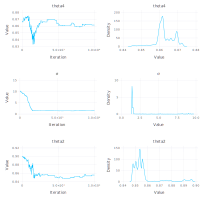

Press ENTER to draw next plot


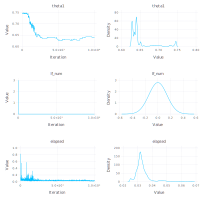

Press ENTER to draw next plot


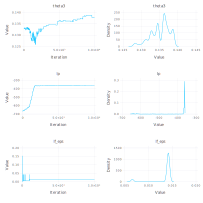

In [70]:
plot_chain(bayesian_result_turing)

In [8]:
@time bayesian_result_stan = stan_inference(prob,t,rand_sol,priors;num_samples=100,num_warmup=500,reltol=1e-5,abstol=1e-5,vars =(StanODEData(),InverseGamma(3,2)))


File /Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.stan --o=/Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.stan
Output file=/Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
c++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math/ -DFUSION_MAX_VECTOR_SIZE=12 -Wno-unused-local-typedefs -DEIGEN_NO_DEBUG -DNO_FPRINTF_OUTPUT -pipe    -O3 -o /Users/vaibhav/JuliaCon/tmp/parameter_estimat

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[1] is 0, but must be > 0!  (in '/Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.stan' at line 37)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[2] is 0, but must be > 0!  (in '/Users/vaibhav/JuliaCon/tmp/parameter_estimation_model.stan' at line 37)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Info


Calling /Users/vaibhav/Downloads/cmdstan-2.17.1/bin/stansummary to infer across chains.

Inference for Stan model: parameter_estimation_model_model
4 chains: each with iter=(100,100,100,100); warmup=(0,0,0,0); thin=(1,1,1,1); 400 iterations saved.

Warmup took (39, 39, 430, 79) seconds, 9.8 minutes total
Sampling took (8.0, 7.7, 76, 11) seconds, 1.7 minutes total

                 Mean     MCSE  StdDev        5%   50%   95%  N_Eff  N_Eff/s    R_hat
lp__             -5.3  1.3e+02     191  -1.4e+02   -83   324    2.0    0.020  1.1e+02
accept_stat__    0.87  7.1e-02    0.22   2.4e-01  0.97  1.00    9.8    0.096  1.2e+00
stepsize__      0.079  3.5e-02   0.049   2.0e-03  0.11  0.13    2.0    0.020  5.3e+15
treedepth__       5.6  9.0e-01     1.8   4.0e+00   5.0    10    4.0    0.039  1.4e+00
n_leapfrog__      159  1.6e+02     296   1.5e+01    31  1023    3.5    0.034  1.5e+00
divergent__     0.023  7.4e-03    0.15   0.0e+00  0.00  0.00    400      3.9  1.0e+00
energy__          8.4  1.3e+02

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-132.17 0.999663 … 0.194349 0.564468; -131.731 0.981787 … 0.197132 0.516894; … ; -135.082 0.992173 … 0.197851 0.617551; -133.629 0.995493 … 0.1965 0.582652]

[-133.381 0.990169 … 0.187275 0.60219; -132.778 0.974204 … 0.199087 0.558363; … ; -132.059 0.991042 … 0.194572 0.570121; -133.857 0.986426 … 0.196209 0.508994]

[-77.289 0.887923 … 0.0472075 0.470308; -76.8819 0.974037 … 0.047262 0.467481; … ; -72.5817 0.945064 … 0.0479816 0.477125; -74.067 0.718419 … 0.0471554 0.484418]

[320.663 0.938476 … 0.0794221 0.50367; 321.35 0.934994 … 0.0815533 0.498252; … ; 322.974 0.994397 … 0.0801111 0.506106; 324.183 0.990054 … 0.0799486 0.503381])

In [9]:
Mamba.describe(bayesian_result_stan.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                   Mean           SD         Naive SE        MCSE         ESS   
         lp__  -5.260232250 190.887255843  9.5443627921 110.065149652  3.0078364
accept_stat__   0.874191752   0.221601648  0.0110800824   0.058165287 14.5150397
   stepsize__   0.079058123   0.049027684  0.0024513842   0.028270742  3.0075188
  treedepth__   5.562500000   1.795592976  0.0897796488   0.682280184  6.9261243
 n_leapfrog__ 159.125000000 295.695678376 14.7847839188 122.237456446  5.8516905
  divergent__   0.022500000   0.148488626  0.0074244313   0.022500000 43.5533278
     energy__   8.385056250 190.946190426  9.5473095213 110.095287244  3.0080465
     sigma1.1   1.069285290   0.570009025  0.0285004513   0.325060111  3.0749362
     sigma1.2   0.575889396   0.286857393  0.0143428697   0.163737363  3.0692800
       theta1   0.703869772   0.105065072  0.0052532536   0.053828573  3.809

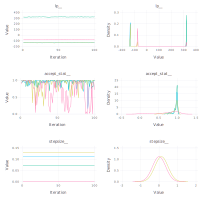

Press ENTER to draw next plot


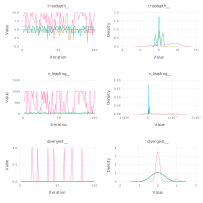

Press ENTER to draw next plot


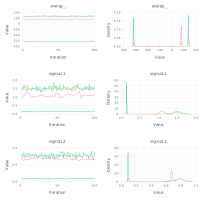

Press ENTER to draw next plot


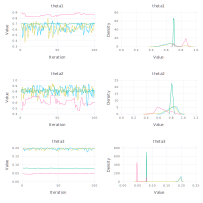

Press ENTER to draw next plot


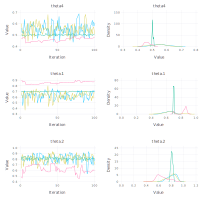

Press ENTER to draw next plot


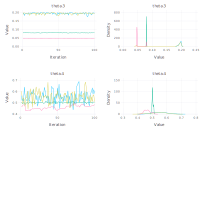

In [10]:
plot_chain(bayesian_result_stan)

In [15]:
@time bayesian_result_dynamic = dynamichmc_inference(prob, rand_sol, priors, t, [bridge(ℝ, Segment(0.0,1.0)),bridge(ℝ,Segment(0.0,1.0)),bridge(ℝ, Segment(0.0,1.0)),bridge(ℝ,Segment(0.0,1.0))],ϵ=0.01,initial=[0.0,0.0,0.0,0.0])

LoadError: [91mAssertionError: chunk size cannot be greater than length(x) (10 > 4)[39m